In [1]:
#!pip install -U pandas-profiling

### (1) Import basic libs

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection # for splitting the data into training and testing data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os
print(os.listdir("./data"))

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

['autos.csv', 'cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv', 'data_e_commerce.csv']


### (2) Read the data

In [3]:
#https://www.kaggle.com/orgesleka/used-cars-database
file = "./data/autos.csv"
print('Filesize [MByte]: {}'.format(str(float(os.stat(file).st_size/1E6))))

Filesize [MByte]: 68.439217


In [4]:
train_data = pd.read_csv(file ,encoding = "ISO-8859-1" )

### (3) Explorative data analysis (EDA) 

In [5]:
train_data.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

In [6]:
profile = ProfileReport(train_data, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

### (4) Cleaning

In [7]:
train_data = train_data.drop(["name","seller","offerType","nrOfPictures","dateCrawled","dateCreated","lastSeen", "postalCode"], axis=1)

In [8]:
gearbox = train_data["gearbox"].unique()
brand = train_data["brand"].unique()

In [9]:
brand_n = train_data["brand"].value_counts().sort_values(ascending=False).iloc[0:8]
idx=list(brand_n.index)
df_new=train_data.loc[train_data['brand'].isin(idx)]
df_new.brand.value_counts()

volkswagen       79640
bmw              40274
opel             40136
mercedes_benz    35309
audi             32873
ford             25573
renault          17969
peugeot          11027
Name: brand, dtype: int64

In [10]:
#
df= df_new.groupby(['brand', 'gearbox'])['brand'].count().unstack('gearbox')
df['summe']=df.apply(lambda x: x['manuell']+x['automatik'],axis=1)

In [11]:
df_val_counts = df.summe.sort_values(ascending=False)
df_val_counts.index

Index(['volkswagen', 'bmw', 'opel', 'mercedes_benz', 'audi', 'ford', 'renault',
       'peugeot'],
      dtype='object', name='brand')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

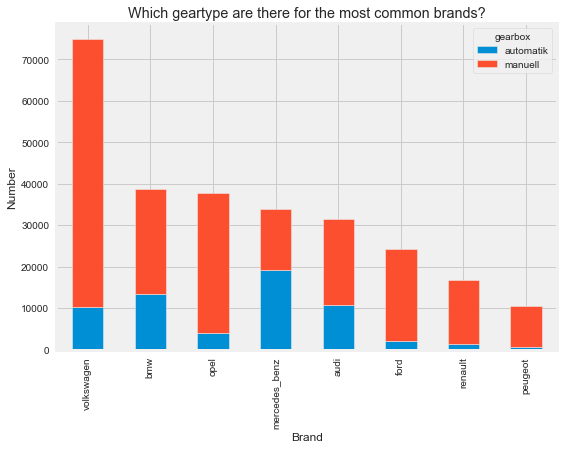

In [12]:
ax = df[['automatik','manuell']].set_index(df.index).loc[df_val_counts.index].plot(figsize=(8,6), kind='bar', stacked=True)
plt.xlabel("Brand")
plt.ylabel("Number")
plt.title("Which geartype are there for the most common brands?");
plt.xticks(rotation=90)

In [13]:
#NaN values of gearbox
train_data["gearbox"].isnull().sum()

20209

In [14]:
#Fill gearbox by brand
d = {}

for i in brand :
    m = 0
    for j in gearbox :
        if train_data[(train_data.gearbox == j) & (train_data.brand == i)].shape[0] > m :
            m = train_data[(train_data.gearbox == j) & (train_data.brand == i)].shape[0]
            d[i] = j

In [15]:
for i in brand :
    train_data.loc[(train_data.brand == i) & (train_data.gearbox.isnull()) ,"gearbox" ] = d[i]

In [16]:
train_data["gearbox"].isnull().sum()

0

In [17]:
#NaN values of notRepairedDamage
train_data["notRepairedDamage"].isnull().sum()

72060

In [18]:
train_data["notRepairedDamage"].fillna("nein",inplace = True)

In [19]:
#NaN values for fuelType
train_data["fuelType"].value_counts()

benzin     223857
diesel     107746
lpg          5378
cng           571
hybrid        278
andere        208
elektro       104
Name: fuelType, dtype: int64

In [20]:
train_data["fuelType"].fillna("benzin",inplace = True)

In [21]:
#NaN values for vehicleType
train_data.groupby("fuelType")["vehicleType"].value_counts()

fuelType  vehicleType
andere    limousine         51
          andere            44
          kleinwagen        29
          kombi             25
          bus               10
          suv                9
          cabrio             6
          coupe              3
benzin    kleinwagen     72531
          limousine      66300
          kombi          31350
          cabrio         20769
          coupe          15935
          bus            10795
          suv             5400
          andere          1786
cng       bus              240
          kombi            136
          kleinwagen        80
          limousine         40
          andere            14
          suv                4
          cabrio             3
          coupe              3
diesel    kombi          34848
          limousine      27648
          bus            18622
          suv             8665
          kleinwagen      6808
          coupe           2737
          cabrio          1871
          andere 

In [22]:
vehicleType = train_data["vehicleType"].unique()
fuelType = train_data["fuelType"].unique()
d = {}
for i in fuelType :
    m = 0
    for j in vehicleType :
        if train_data[(train_data.vehicleType == j) & (train_data.fuelType == i)].shape[0] > m :
            m = train_data[(train_data.vehicleType == j) & (train_data.fuelType == i)].shape[0]
            d[i] = j

In [23]:
for i in fuelType :
    train_data.loc[(train_data.fuelType == i) & (train_data.vehicleType.isnull()) ,"vehicleType" ] = d[i]

In [24]:
train_data["vehicleType"].isnull().sum()

0

In [25]:
#NaN in model 
train_data["model"].fillna(train_data["model"].unique()[0],inplace =True)

In [26]:
#finally
train_data.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [27]:
train_data.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
kilometer               int64
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
dtype: object

In [28]:
train_data.select_dtypes(include=[np.number]).corr().iloc[0,0]

1.0

In [29]:
#show correlations
def correlation_graph(a):
    a=a.select_dtypes(include=[np.number])
    corr = a.corr()
    matrix = np.triu(corr)
    names = list(a.columns)
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, 
                   cmap="YlGnBu", linewidths=3, linecolor='white', mask=matrix)
    plt.yticks(rotation=45)
    #cmap= 'coolwarm'
    #plt.colorbar()
    #plt.xticks(range(len(corr)), corr.columns);
    #plt.yticks(range(len(corr)), corr.columns);
    #ax.tick_params(left=True)
    plt.suptitle('Car Correlations Heat Map', fontsize=15, fontweight='bold')
    plt.show()

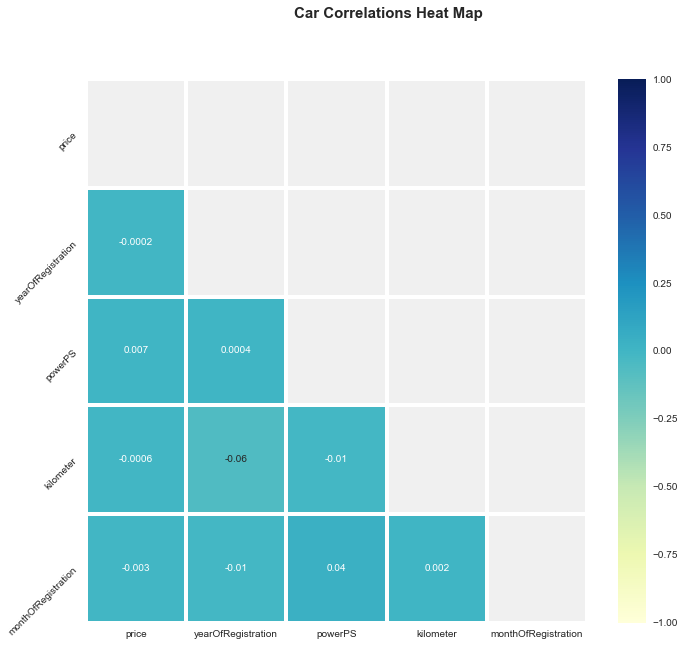

In [30]:
correlation_graph(train_data)

### (5) Preparation for the modelling

In [31]:
data = train_data.copy()
data = pd.get_dummies(data, columns=["vehicleType"], prefix='vT')
data = pd.get_dummies(data, columns=["fuelType"], prefix='fT')
data = pd.get_dummies(data, columns=["gearbox"], prefix='gb')
data = pd.get_dummies(data, columns=["notRepairedDamage"], prefix='nRD')
data = pd.get_dummies(data, columns=["brand"], prefix='b')
data = pd.get_dummies(data, columns=["model"], prefix='m')
data = pd.get_dummies(data, columns=["abtest"], prefix='a')

In [32]:
data["yearOfRegistration"].describe()

count    371528.000000
mean       2004.577997
std          92.866598
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: yearOfRegistration, dtype: float64

In [33]:
data = data[(data.yearOfRegistration < 2017)  & (data.yearOfRegistration > 1950)]

In [34]:
data["price"].describe()

count    3.565370e+05
mean     1.739899e+04
std      3.658497e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.999000e+03
75%      7.400000e+03
max      2.147484e+09
Name: price, dtype: float64

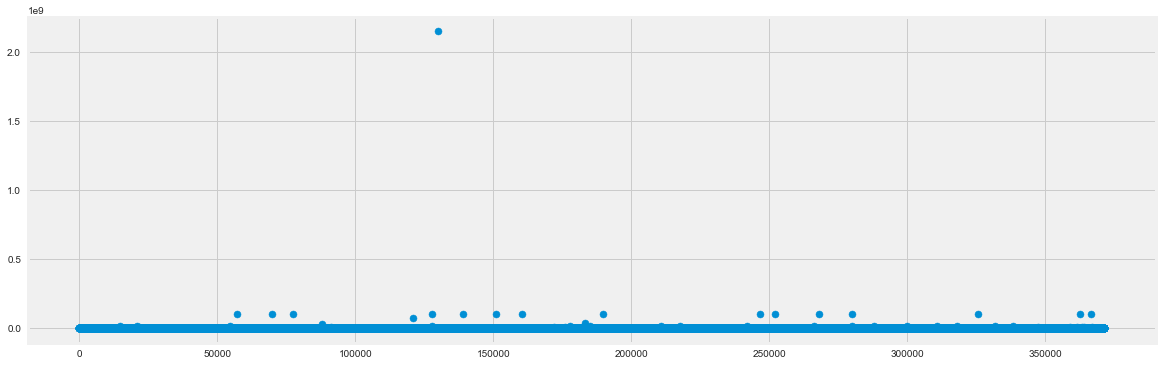

In [35]:
plt.figure(figsize=(18,6))
plt.scatter(x=data.index, y=data['price'])

In [36]:
data = data[(data.price > 100) & (data.price < 200000) ]

In [37]:
y  = data["price"]
X =  data.drop("price",axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### (6) Modelling

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [40]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from timeit import default_timer as timer

# Ridge Regressor
alphas = [0.1, 0.01]
max_iters = [200, 2000]
keys = ['alpha','max_iter']
values = [alphas,max_iters]
param_grid_ridge = dict(zip(keys, values))
ridge_model = Ridge(fit_intercept=True)

# Decision Tree
min_tree_splits = range(2,3)
min_tree_leaves = range(2,3)
param_grid_tree = dict(min_samples_split=min_tree_splits,
                       min_samples_leaf=min_tree_leaves)
tree_model = DecisionTreeRegressor()

# AdaBoost
estimators_space = [50]
learning_rate_space = [0.5, 0.1]
param_grid_adaboost = dict(learning_rate=learning_rate_space,
                       n_estimators=estimators_space)
adaboost_model = AdaBoostRegressor()

cv = 5

#models_to_test = ['Ridge','DecisionTreeRegressor','AdaBoostRegressor']
#regression_dict = dict(Ridge=ridge_model,
#                       DecisionTreeRegressor=tree_model, 
#                       AdaBoostRegressor=adaboost_model)
#param_grid_dict = dict(Ridge=param_grid_ridge,
#                       DecisionTreeRegressor=param_grid_tree, 
#                       AdaBoostRegressor=param_grid_adaboost)

models_to_test = ['Ridge','DecisionTreeRegressor']
regression_dict = dict(Ridge=ridge_model,
                       DecisionTreeRegressor=tree_model)
param_grid_dict = dict(Ridge=param_grid_ridge,
                       DecisionTreeRegressor=param_grid_tree)

score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}
time_dict={}

for model in models_to_test:
    start = timer()
    regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    # Print the tuned parameters and score
    print(" === Start report for regressor {} ===".format(model))
    print()
    score_dict[model] = regressor.best_score_
    print("Tuned Parameters: {}:".format(regressor.best_params_)) 
    params_dict = regressor.best_params_
    print("Best score is {}:".format(regressor.best_score_))

    # Compute metrics
    mae_dict[model] = mean_absolute_error(y_test, y_pred)
    print("MAE for {}:".format(model))
    print(mean_absolute_error(y_test, y_pred))
    mse_dict[model] = mean_squared_error(y_test, y_pred)
    print("MSE for {}:".format(model))
    print(mean_squared_error(y_test, y_pred))
    r2_dict[model] = r2_score(y_test, y_pred)
    print("R2 score for {}:".format(model))
    print(r2_score(y_test, y_pred))
    print()
    end = timer()
    time_dict[model]=round((end - start),3)
    print('Time consumption [s]: ', round((end - start),3))
    print()
    print(" === End of report for regressor {} === \n\n".format(model))

    # Add best estimator to the dict
    best_est_dict[model] = regressor.best_estimator_

 === Start report for regressor Ridge ===

Tuned Parameters: {'alpha': 0.1, 'max_iter': 200}:
Best score is 0.5785941688976112:
MAE for Ridge:
2881.9004025998456
MSE for Ridge:
29802656.852189768
R2 score for Ridge:
0.5749495687293658

Time consumption [s]:  17.995

 === End of report for regressor Ridge === 


 === Start report for regressor DecisionTreeRegressor ===

Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2}:
Best score is 0.7504409618683368:
MAE for DecisionTreeRegressor:
1541.3196995843957
MSE for DecisionTreeRegressor:
16222640.43975579
R2 score for DecisionTreeRegressor:
0.7686300134425772

Time consumption [s]:  44.075

 === End of report for regressor DecisionTreeRegressor === 




Feature: yearOfRegistration, Score: 0.36646
Feature: powerPS, Score: 0.32169
Feature: kilometer, Score: 0.08464
Feature: monthOfRegistration, Score: 0.02153
Feature: vT_andere, Score: 0.00017
Feature: vT_bus, Score: 0.00057
Feature: vT_cabrio, Score: 0.00974
Feature: vT_coupe, Score: 0.00476
Feature: vT_kleinwagen, Score: 0.00712
Feature: vT_kombi, Score: 0.00138
Feature: vT_limousine, Score: 0.00295
Feature: vT_suv, Score: 0.00416
Feature: fT_andere, Score: 0.00000
Feature: fT_benzin, Score: 0.00349
Feature: fT_cng, Score: 0.00000
Feature: fT_diesel, Score: 0.00427
Feature: fT_elektro, Score: 0.00008
Feature: fT_hybrid, Score: 0.00004
Feature: fT_lpg, Score: 0.00011
Feature: gb_automatik, Score: 0.00268
Feature: gb_manuell, Score: 0.00544
Feature: nRD_ja, Score: 0.00213
Feature: nRD_nein, Score: 0.00226
Feature: b_alfa_romeo, Score: 0.00016
Feature: b_audi, Score: 0.00429
Feature: b_bmw, Score: 0.00386
Feature: b_chevrolet, Score: 0.00045
Feature: b_chrysler, Score: 0.00006
Feature: b

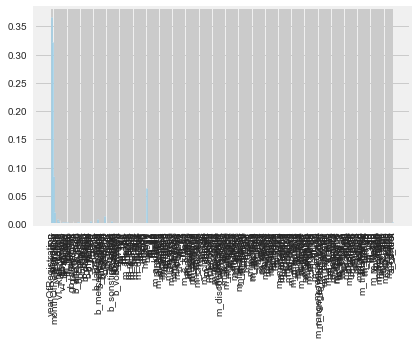

In [41]:
importance = best_est_dict['DecisionTreeRegressor'].feature_importances_
for i,v in enumerate(importance):
     print('Feature: %s, Score: %.5f' % (X.columns.values.tolist()[i],v))
# plot feature importance
plt.bar(X.columns.values.tolist(), importance)
plt.xticks(rotation=90)
plt.show()

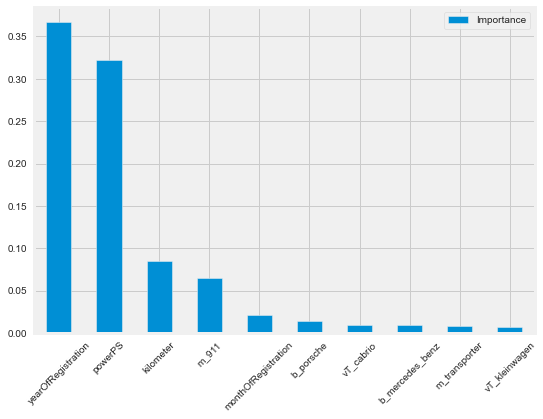

In [42]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, importance):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values(by='Importance', ascending=False)[:10]
importances.plot(figsize=(8,6),kind='bar', rot=45)

Text(0.5, 1.0, 'Regressor Comparison')

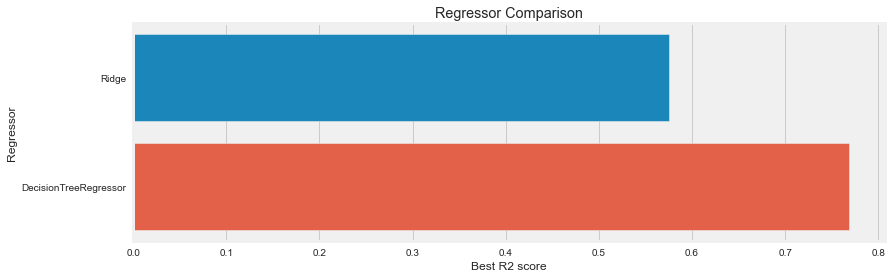

In [43]:
# Creating summary report for score
summary_cols = ['Best Score']
summary = pd.DataFrame.from_dict(r2_dict, orient='index')
summary.index.name = 'Regressor'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizing results
plt.figure(figsize=(12,4))
sns.barplot(x='Best Score', y='Regressor', data=summary)
plt.xlabel('Best R2 score')
plt.title('Regressor Comparison')

Text(0.5, 1.0, 'Regressor Comparison')

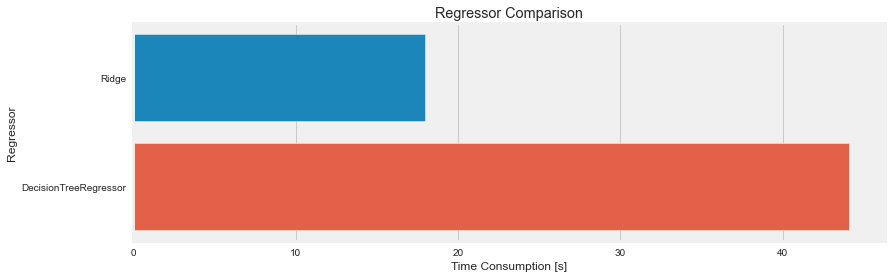

In [44]:
# Creating summary report for time consumption
summary_cols_t = ['Time Consumption']
summary_t = pd.DataFrame.from_dict(time_dict, orient='index')
summary_t.index.name = 'Regressor'
summary_t.columns = summary_cols_t
summary_t = summary_t.reset_index()

plt.figure(figsize=(12,4))
sns.barplot(x='Time Consumption', y='Regressor', data=summary_t)
plt.xlabel('Time Consumption [s]')
plt.title('Regressor Comparison')

### (7) Forecast

In [45]:
testcase=pd.DataFrame(data.iloc[4711]).T
testcase.T.head(50)

5138
price                  7500
yearOfRegistration     2007
powerPS                 140
kilometer            150000
monthOfRegistration       8
vT_andere                 0
vT_bus                    0
vT_cabrio                 0
vT_coupe                  0
vT_kleinwagen             0
vT_kombi                  1
vT_limousine              0
vT_suv                    0
fT_andere                 0
fT_benzin                 0
fT_cng                    0
fT_diesel                 1
fT_elektro                0
fT_hybrid                 0
fT_lpg                    0
gb_automatik              1
gb_manuell                0
nRD_ja                    0
nRD_nein                  1
b_alfa_romeo              0
b_audi                    1
b_bmw                     0
b_chevrolet               0
b_chrysler                0
b_citroen                 0
b_dacia                   0
b_daewoo                  0
b_daihatsu                0
b_fiat                    0
b_ford                    0
b_honda                   0
b_hyundai                 0
b_jaguar                  0
b_jeep                    0
b_kia                     0
b_lada                    0
b_lancia                  0
b_land_rover              0
b_mazda                   0
b_mercedes_benz           0
b_mini                    0
b_mitsubishi              0
b_nissan                  0
b_opel                    0
b_peugeot                 0

In [46]:
testcase_x=np.array(testcase.drop(columns=['price']))
testcase_x=sc.transform(testcase_x)
#testcase_x

In [47]:
pred=[]
for i in best_est_dict.values():
    pred.append([i,i.predict(testcase_x)[0]])
    
pred

[[Ridge(alpha=0.1, max_iter=200), 10162.481555516086],
 [DecisionTreeRegressor(min_samples_leaf=2), 6900.0]]